# Association Rule Mining for reported street crimes in England & Wales
The aim here is to see if there are any associations between the reported aspects of street crime, such as Month of Year, Location, Crime type etc.
This will be done in Pyspark due to the size of the data but it will still be possible to execute on a local cluster.

The data can be downloaded from here: https://data.police.uk/data/.

The date range for this data is December 2010 - July 2019 and all constabularies in England & Wales were selected (we will be excluding British Transport Police and Police Service of Northern Ireland)

# Preparatory steps

Before going into the details of the analysis, we need to carry out some preparatory steps in order to have a Spark installation ready in our Google Collab. The following steps take care of the installation of all the dependencies and test the resulting environment, to check that everything is working.

NOTE: These instructions have been obtained from: https://joserzapata.github.io/es/post/pyspark-google-colab/

First, we must install Java 8 JDK.

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

Next, we retrieve all the available stable Spark versions from the web.

In [2]:
from bs4 import BeautifulSoup
import requests

url = 'https://downloads.apache.org/spark/' 
r = requests.get(url)
html_doc = r.text
soup = BeautifulSoup(html_doc)

link_files = []
for link in soup.find_all('a'):
  link_files.append(link.get('href'))
spark_link = [x for x in link_files if 'spark' in x]  
print(spark_link)

['spark-2.4.7/', 'spark-3.0.1/']


Now, the most recent version is selected.

In [3]:
ver_spark = spark_link[1][:-1] # obtener la version y eliminar el caracter '/' del final
print(ver_spark)

spark-3.0.1


We install both Spark and the pyspark wrapper.

In [4]:
import os

link = "https://www-us.apache.org/dist/spark/"
os.system(f"wget -q {link}{ver_spark}/{ver_spark}-bin-hadoop2.7.tgz")
os.system(f"tar xf {ver_spark}-bin-hadoop2.7.tgz")

!pip install -q pyspark

Once installed, we point the corresponding environment variables to the location of both libraries.

In [5]:
os.environ["JAVA_HOME" ]="/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"]=f"/content/{ver_spark}-bin-hadoop2.7"

Now is time to start a Spark session and test that everything is working.

In [6]:
from pyspark.sql import SparkSession
spark=SparkSession.builder.appName("Test_spark").master("local[*]").getOrCreate()
spark

We can read one of the sample files and check that we obtain a Data frame.

In [7]:
archivo = './sample_data/california_housing_train.csv'
df_spark = spark.read.csv(archivo, inferSchema=True, header=True)

print(type(df_spark))

<class 'pyspark.sql.dataframe.DataFrame'>


And we can check what we read by printing the number of rows, the schema, column names and the first 20 rows of the data frame.

In [8]:
df_spark.count()

17000

In [9]:
df_spark.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)



In [10]:
df_spark.columns

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'median_house_value']

In [11]:
df_spark.show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+
|  -114.31|   34.19|              15.0|     5612.0|        1283.0|    1015.0|     472.0|       1.4936|           66900.0|
|  -114.47|    34.4|              19.0|     7650.0|        1901.0|    1129.0|     463.0|         1.82|           80100.0|
|  -114.56|   33.69|              17.0|      720.0|         174.0|     333.0|     117.0|       1.6509|           85700.0|
|  -114.57|   33.64|              14.0|     1501.0|         337.0|     515.0|     226.0|       3.1917|           73400.0|
|  -114.57|   33.57|              20.0|     1454.0|         326.0|     624.0|     262.0|        1.925|           65500.0|
|  -114.58|   33.63|    

As everything seems to be working, we can proceed with our analysis.

## What is an Association Rule?
*Association rule learning is a rule-based machine learning method for discovering interesting relations between variables in large databases. It is intended to identify strong rules discovered in databases using some measures of interestingness. This rule-based approach also generates new rules as it analyzes more data. The ultimate goal, assuming a large enough dataset, is to help a machine mimic the human brain’s feature extraction and abstract association capabilities from new uncategorized data.*

We will be looking for rules with a high level of confidence

*Confidence is an indication of how often the rule has been found to be true... Confidence can be interpreted as an estimate of the conditional probability*

In [12]:
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
import calendar
import seaborn as sns

In [13]:
%load_ext autoreload
%autoreload 2

#### Set up Spark
Running Spark locally using 6 out of 8 cores

In [14]:
from pyspark import SparkContext
from pyspark.sql import SQLContext, SparkSession

In [15]:
spark = SparkSession.builder\
        .master("local[7]")\
        .appName("Crime Assocations")\
        .config("spark.executor.memory", "6g")\
        .config("spark.memory.fraction", 0.7)\
        .getOrCreate()

In [16]:
sc = spark.sparkContext
# Set up a SQL Context
sqlCtx = SQLContext(sc)

In [17]:
#sc.stop()

## Load Data into Spark

In [18]:
def load_data(file_locations, sqlcontext):
    print("Loading CSV files to sqlcontext...")
    police_data_df = sqlcontext.read.format("csv")\
                .option("header", "true")\
                .option("inferSchema", "true")\
                .load(file_locations)
    print('Load Complete')
    return police_data_df

We must download and uncompress our data within the Colab VM.

In [19]:
import os

link = "https://github.com/tonitonae/EnglandCrimeAssociations/releases/download/v0.1/data_full.zip"
os.system(f"wget -q {link}")
os.system(f"unzip data_full.zip")

0

The police data comes in several csv files with a folder for each Month-Year. Within each folder, there is a CSV file for each constabulary. We will concatenate these

In [20]:
path = glob.glob(os.getcwd() + "/data_full/*/*-street.csv")

In [21]:
police_data_df = load_data(file_locations=path, sqlcontext=sqlCtx)

Loading CSV files to sqlcontext...
Load Complete


#### Inspecting the data

In [22]:
police_data_df.select(police_data_df.columns[1:]).show()

+-------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+--------------------+---------------------+-------+
|  Month|         Reported by|        Falls within|Longitude| Latitude|            Location|LSOA code|           LSOA name|          Crime type|Last outcome category|Context|
+-------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+--------------------+---------------------+-------+
|2020-05|Metropolitan Poli...|Metropolitan Poli...|-0.549112| 50.82404|On or near Finche...|E01031467|           Arun 004D|Violence and sexu...| Investigation com...|   null|
|2020-05|Metropolitan Poli...|Metropolitan Poli...|-1.046477|51.820056| On or near The Firs|E01017642| Aylesbury Vale 010A|Violence and sexu...|  Under investigation|   null|
|2020-05|Metropolitan Poli...|Metropolitan Poli...| -0.77491|51.810753|On or near Beaufo...|E01017640| Aylesbury Vale 017F|  

Each dataset contains the following columns:

In [23]:
police_data_df.printSchema()

root
 |-- Crime ID: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Reported by: string (nullable = true)
 |-- Falls within: string (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- LSOA code: string (nullable = true)
 |-- LSOA name: string (nullable = true)
 |-- Crime type: string (nullable = true)
 |-- Last outcome category: string (nullable = true)
 |-- Context: string (nullable = true)



The Data Dictionary is as follows

In [24]:
# dictionary = pd.read_csv('data_dictionary.csv')

In [25]:
# pd.set_option('display.max_colwidth', -1)
# for elem in dictionary.to_records(index=False):
#     print(elem[0] + ": " + elem[1])

NOTE: LSOA (Lower Layer Super Output Area)

From NHS Data Dictionary (https://www.datadictionary.nhs.uk/data_dictionary/nhs_business_definitions/l/lower_layer_super_output_area_de.asp?shownav=1)
    
"<i>A Lower Layer Super Output Area (LSOA) is a GEOGRAPHIC AREA.
Lower Layer Super Output Areas are a geographic hierarchy designed to improve the reporting of small area statistics in England and Wales.
Lower Layer Super Output Areas are built from groups of contiguous Output Areas and have been automatically generated to be as consistent in population size as possible, and typically contain from four to six Output Areas. The Minimum population is 1000 and the mean is 1500.
There is a Lower Layer Super Output Area for each POSTCODE in England and Wales</i>"

How many Rows do we have?

In [26]:
num_rows = police_data_df.count()

In [27]:
num_rows

18980331

## Cleaning the Data

In [28]:
import pyspark.sql.functions as F
import calendar

# In order to convert the month from a number representing the month index, this function has been created to map that index
# to its 3 letter abbreviation
get_month_name = F.udf(lambda x: calendar.month_abbr[x])

def clean_months(df):
    print('Cleaning Year and Month Columns...')
    
    # Split the month column into a a Month number and a Year
    month_year_split = F.split(df['Month'], '-')
    
    # Assign the Year and Month Number as new columns
    df = df.withColumn('Year', month_year_split.getItem(0))\
                    .withColumn('Month_of_Year', month_year_split.getItem(1))
    
    print('Creating Month_of_Year and Year columns...')
    # Ensure that both of the new columns created are integer and not string types
    df = df.withColumn("Month_of_Year", df.Month_of_Year.cast("int"))\
                    .withColumn("Year", df.Year.cast("int"))
    
    # Ensure the month is a name of a month
    df_with_month = df.withColumn("Month_of_Year", get_month_name(df["Month_of_Year"]))
    
    print('Cleaning Complete')

    return df_with_month


def clean_location(df):
    # Remove the On or near part of the string in Location as it adds no information
    #' Remove the code at the end of LSOA name to get the Town/City
    print('Cleaning Location and Town and City...')
    df_with_location = df.withColumn('Location', F.regexp_replace('Location', 'On or near ', ''))\
                        .withColumn("Town_City", F.regexp_replace('LSOA name', ' [0-9]{3}\w', ''))
    print('Cleaning Complete')
    return df_with_location

def clean_non_england(df):
    print('Removing non England and Wales entries')
    df_england = df.where((df["Falls within"] != "Police Service of Northern Ireland") & (df["Falls within"] != "British Transport Police"))
    print('Removal Complete')
    return df_england


In [29]:
# The month column in the data is actually a Year-Month, here we will split that on the - delimiter and create a Year and Month_of_Year Column
police_data_clean = clean_months(police_data_df)
# Now lets create a Location and Town/City Column
police_data_clean = clean_location(police_data_clean)
police_data_clean = clean_non_england(police_data_clean)

Cleaning Year and Month Columns...
Creating Month_of_Year and Year columns...
Cleaning Complete
Cleaning Location and Town and City...
Cleaning Complete
Removing non England and Wales entries
Removal Complete


In [30]:
police_data_clean.printSchema()

root
 |-- Crime ID: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Reported by: string (nullable = true)
 |-- Falls within: string (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- LSOA code: string (nullable = true)
 |-- LSOA name: string (nullable = true)
 |-- Crime type: string (nullable = true)
 |-- Last outcome category: string (nullable = true)
 |-- Context: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month_of_Year: string (nullable = true)
 |-- Town_City: string (nullable = true)



## Exploratory Analysis

In [31]:
import pyspark.sql.functions as F

In [32]:
import calendar
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from plotnine import ggplot, geoms
import pyspark.sql.functions as F

sns.set_style('darkgrid')
colours = sns.color_palette("PuBu", 10)

def plot_crime_time_series(df, read=False):
    """
    
    Plots the number of crimes that occured each month'
    
    """
    
    if read:
        crime_over_time = pd.read_csv("./eda_data/crime_over_time.csv", 
                                      usecols = ["Month_of_Year", "Year", "count"])
    else:
        print('Grouping by Month and Year and collecting to Pandas...')
        crime_over_time = df\
                         .groupBy(["Month_of_Year", "Year"])\
                         .count()\
                         .toPandas()
        print('Collected to Pandas')
        crime_over_time.to_csv("./eda_data/crime_over_time.csv")
    
    
    print('Setting Month to a categorical variable...')
    months = map(lambda x: calendar.month_abbr[x], range(1, 13))
    crime_over_time["Month_of_Year"] = pd.Categorical(crime_over_time["Month_of_Year"], categories=months)
    print('Setting complete')
    
    print('Converting to Series object...')
    crime_time_series = crime_over_time\
                        .set_index(["Year", "Month_of_Year"])\
                        .sort_index()\
                        .squeeze()
    print('Conversion complete')
    
    print('Creating plot object')
    plot = crime_time_series.plot(kind = "line", color="b", title = "Incidents of Reported Street Crime (Dec 2010 - Jul 2019)")
    
    plot.set_xticks(range(0, len(crime_time_series.index)))
    plot.set_xticklabels(list(crime_time_series.index), rotation=90)
    print("Complete.. Plotting...")

    return plot

def plot_crime_counts(df, read=False):
    
    if read:
        crime_type_counts = pd.read_csv("./eda_data/crime_type_counts.csv", usecols=['Crime type', 'count'])
    
    else:
        print('Grouping by Crime type and collecting to Pandas..')
        crime_type_counts = df\
                        .groupBy(df['Crime type'])\
                        .count()\
                        .sort(F.col("count").desc())\
                        .toPandas()
        crime_type_counts.to_csv("./eda_data/crime_type_counts.csv", header=True)
    
    print('Converting to Series object...')
    crime_type_counts_series = crime_type_counts\
                               .set_index("Crime type")\
                               .squeeze()\
                               .apply(lambda x: x*100/sum(crime_type_counts["count"]))
    
    print('Plotting...')
    plot = sns.barplot(x = crime_type_counts_series.values, 
                       y = crime_type_counts_series.index,
                       color='b')
    
    return plot
    
    
def plot_crime_type_and_category_counts(df, read=False):
    
    if read:
        outcome_counts = pd.read_csv("./eda_data/outcome_counts.csv", 
                                     usecols=["Crime type", "Last outcome category", "count"])
    else:
        print('Grouping by Crime type and Outcome Category')
        outcome_counts = df\
                     .groupBy(["Crime type", "Last outcome category"])\
                     .count()\
                     .sort(F.col("count").desc())\
                     .toPandas()
        outcome_counts.to_csv("./eda_data/outcome_counts.csv", header=True)
    
    print('Converting to Series')
    outcome_counts_series = outcome_counts\
                            .set_index(["Crime type", "Last outcome category"])\
                            .squeeze()\
                            .apply(lambda x: x*100/sum(outcome_counts["count"]))\
                            .head(20)
    print('Collapsing Multi Index')
    index = [str(x) + " -> " + str(y) for x, y in outcome_counts_series.index]
    
    print("Plotting...")
    plot = sns.barplot(x = outcome_counts_series.values, y = index, color='b')
        
    plot.set_title('% Total Reported Crime Type and Outcome combination (Dec 2010 - Jul 2019)')
    plot.set_xlabel('% of Reported Crimes') 
    plot.set_ylabel('Crime Type -> Outcome')
    
    return plot

def plot_crime_town_city_counts(df, read=False):
    
    if read:
        crime_town_city_counts = pd.read_csv(
            "./eda_data/crime_town_city_counts.csv", 
            usecols=["Town_City", "count"]
        )        
    else:
        print('Grouping by Town or City')
        crime_town_city_counts = df\
                        .groupBy(df['Town_City'])\
                        .count()\
                        .sort(F.col("count").desc())\
                        .toPandas()
        crime_town_city_counts.to_csv("./eda_data/crime_town_city_counts.csv", header=True)
    
    print('Converting to Series')
    crime_town_city_counts_series = crime_town_city_counts\
                                    .set_index(["Town_City"])\
                                    .squeeze()\
                                    .head(20)
    print('Plotting...')
    plot = sns.barplot(y=crime_town_city_counts_series.index, 
                       x=crime_town_city_counts_series.values,
                       color='b')
    
    plot = plot.set_xticklabels(np.arange(0, max(crime_town_city_counts_series.values), 10000))    
    return plot

#### Are there any cases of when the constabulary that reported the crime is different to the constabulary area?

In [33]:
police_data_clean\
    .where(F.col("Reported by") != F.col("Falls within"))\
    .count()

0

#### Number of Incidents over time

Grouping by Month and Year and collecting to Pandas...
Collected to Pandas
Setting Month to a categorical variable...
Setting complete
Converting to Series object...
Conversion complete
Creating plot object
Complete.. Plotting...


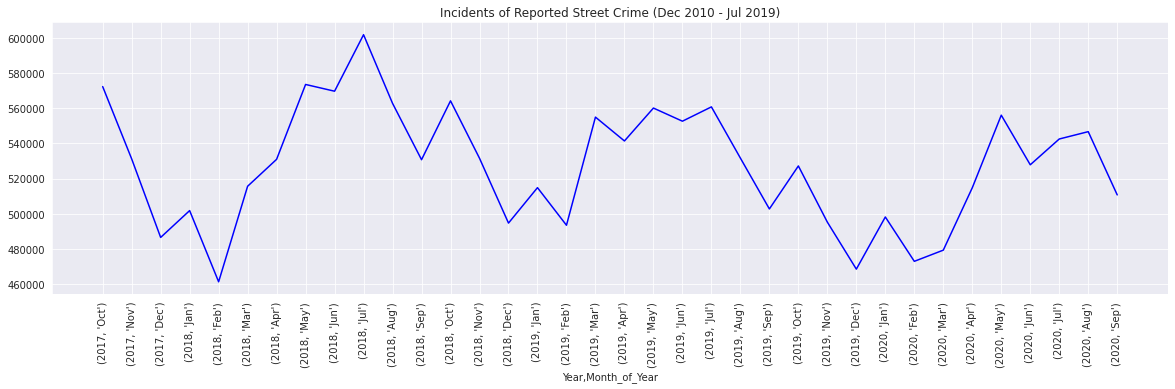

In [34]:
plt.figure(figsize=(20, 5))
crime_over_time_plot = plot_crime_time_series(police_data_clean, read=False)
plt.show()

There appears to be a stationary trend with some periodicity with the numbers of reported crimes, although we do not have complete years in this dataset. It looks like there is a pattern to the level/numbers of street crimes!

#### Most Common Crime and Outcome Category Combination

Grouping by Crime type and Outcome Category
Converting to Series
Collapsing Multi Index
Plotting...


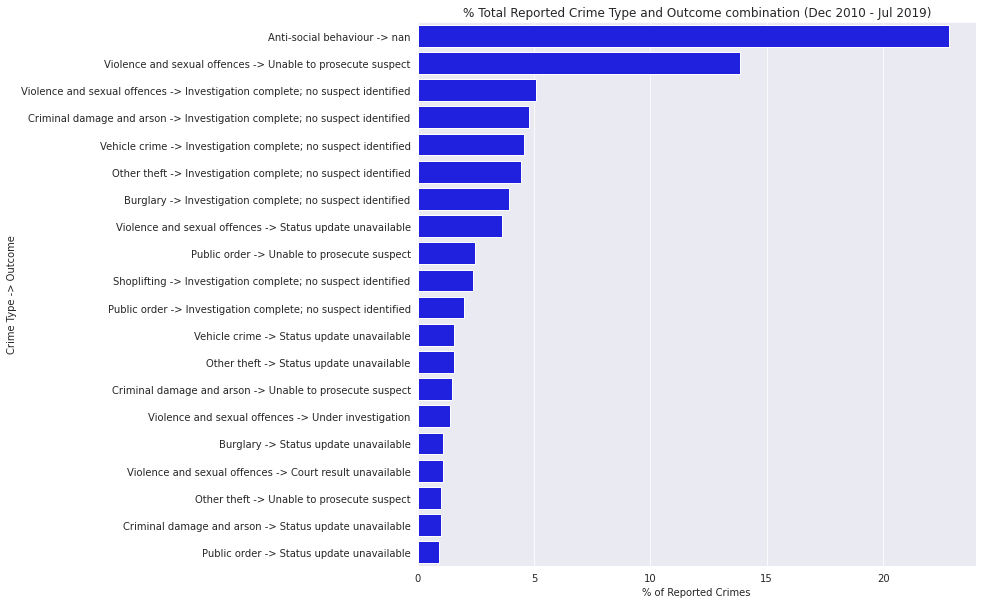

In [35]:
plt.figure(figsize=(10, 10))
outcome_category_plot = plot_crime_type_and_category_counts(police_data_clean, read=False)
plt.show()

It seems the most common type to outcome association is an anti social behaviour crime with no recorded outcome

#### The Most Common Type of Crime

Grouping by Crime type and collecting to Pandas..
Converting to Series object...
Plotting...


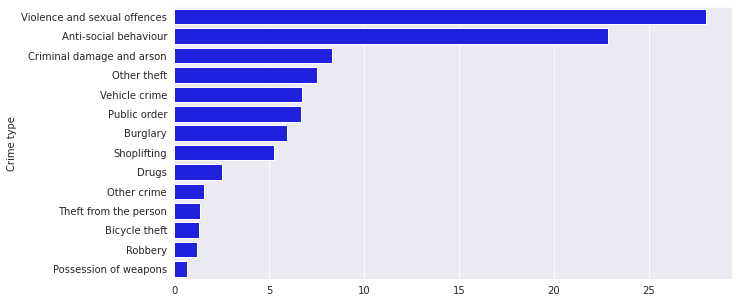

In [36]:
plt.figure(figsize=(10, 5))
crime_type_plot = plot_crime_counts(police_data_clean, read=False)
plt.show()

Anti-social behaviour makes up about 35% of crime in England - which is expected... It is concerning that violence and sexual offences is in second place

#### Which Town or City has the most crime?

Grouping by Town or City
Converting to Series
Plotting...


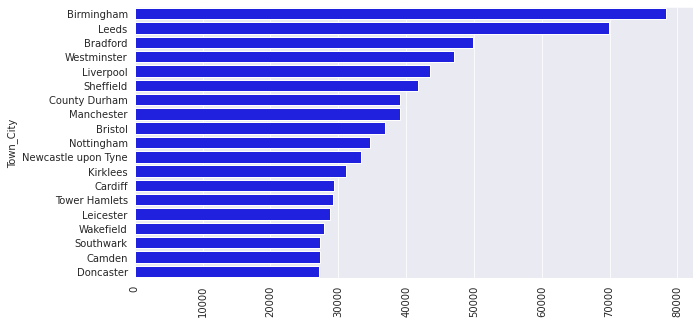

In [37]:
plt.figure(figsize=(10,5))
crime_town_city_counts = plot_crime_town_city_counts(police_data_clean, read=False)
plt.xticks(rotation=90)
plt.show()

## Feature Engineering

Let's look at what the feature engineering code is actually doing

In [38]:
from pyspark.sql.types import ArrayType, StringType
import pyspark.sql.functions as F

clear_duplicates = F.udf(lambda x: list(set(x)), ArrayType(StringType()))

def get_modelling_data(df):
    
    select_cols = ["Falls within", "Town_City", "Crime type", "Last outcome category", "Month_of_Year"]
    
    # Remove the crimes with no crime ID and no LSOA Information.
    # Then select the features of interest
    
    print('Filtering data with no Crime ID and no outcome category..')
    police_data_modelling = df\
        .filter(df["Crime ID"].isNotNull() & df["Last outcome category"].isNotNull())\
        .select(select_cols)
    print('Filtering complete')
    return police_data_modelling

def make_item_sets(df):
    # The FP growth algorithm (like association rules), needs the items to be concatenated into a list/array of "transactions".
    print('Making item sets...')
    print('Collapsing data to list of transactions')
    police_item_set = df.withColumn("items_temp", F.array(df["Falls within"],
                                                     df["Town_City"],
                                                     df["Crime type"],
                                                     df["Last outcome category"],
                                                     df["Month_of_Year"]))
    
    police_item_set = police_item_set.withColumn("items", clear_duplicates(police_item_set["items_temp"]))
    # Select the items column and id
    print('Adding increasing id column...')
    
    police_item_set = police_item_set\
        .select("items")
    print('Itemset creation complete')
    
    return police_item_set


def feature_engineer(df):
    """Invoke the full feature engineering pipeline"""
    print('Starting Feature Engineering pipeline...')
    selected_data = get_modelling_data(df)
    item_sets = make_item_sets(selected_data)
    print('Feature Engineering complete')
    return item_sets


In [39]:
# Remove the crimes with no crime ID and no LSOA Information.
police_item_set = feature_engineer(police_data_clean)

Starting Feature Engineering pipeline...
Filtering data with no Crime ID and no outcome category..
Filtering complete
Making item sets...
Collapsing data to list of transactions
Adding increasing id column...
Itemset creation complete
Feature Engineering complete


The FP growth algorithm (like association rules), needs the items to be concatenated into a list/array of "transactions".

In [40]:
police_item_set.show(truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------+
|items                                                                                                                             |
+----------------------------------------------------------------------------------------------------------------------------------+
|[Metropolitan Police Service, Investigation complete; no suspect identified, Arun, Violence and sexual offences, May]             |
|[Metropolitan Police Service, Violence and sexual offences, Aylesbury Vale, Under investigation, May]                             |
|[Other crime, Awaiting court outcome, Metropolitan Police Service, Aylesbury Vale, May]                                           |
|[Burglary, Barking and Dagenham, Metropolitan Police Service, Investigation complete; no suspect identified, May]                 |
|[Barking and Dagenham, Metropolitan Police Service, Investigation co

## Modelling: Create the FP growth algorithm
For Association rules

In [41]:
from pyspark.ml.fpm import FPGrowth
from pyspark.sql.functions import concat_ws, col
import pandas as pd

def build_association_rule_model(item_set, min_support, min_confidence):
    # Use a low support as we have a large dataset
    fp_growth = FPGrowth(itemsCol="items", minSupport=min_support, minConfidence=min_confidence)
    
    print('Fitting FPGrowth....')
    model = fp_growth.fit(item_set)
    print('Fit Complete')
    return model

def extract_model_rules(model):
    # Extract the association rules from the model
    print('Extracting Rules...')
    rules = model.associationRules
    print('Rule extraction complete')
    
    # Minor tidying to save as pandas dataframe. Antecedent and Consequent are array types
    # Concatenate into one string and sort by highest confidence
    
    print('Collecting Rules to Pandas...')
    rules_df = rules\
            .withColumn("antecedent" ,concat_ws(",", rules["antecedent"]))\
            .withColumn("consequent" ,concat_ws(",", rules["consequent"]))\
            .sort(col("confidence"))\
            .toPandas()
    print('Collection Complete...')
    
    return rules_df

In [42]:
# Use a low support as we have a large dataset
model = build_association_rule_model(police_item_set, min_support=0.01, min_confidence=0.6)

Fitting FPGrowth....
Fit Complete


#### Extract the Association Rules

In [43]:
rules_df_pd = extract_model_rules(model)

Extracting Rules...
Rule extraction complete
Collection Complete...


In [44]:
rules_df_pd

,antecedent,consequent,confidence,lift
0,"Oct,Unable to prosecute suspect",Violence and sexual offences,0.639510,1.763169
1,"Jul,Unable to prosecute suspect",Violence and sexual offences,0.643617,1.774494
2,"Nov,Unable to prosecute suspect",Violence and sexual offences,0.643754,1.774871
3,"May,Unable to prosecute suspect",Violence and sexual offences,0.644047,1.775679
4,"Aug,Unable to prosecute suspect",Violence and sexual offences,0.645047,1.778435
5,"West Yorkshire Police,Unable to prosecute suspect",Violence and sexual offences,0.645211,1.778889
6,"Apr,Unable to prosecute suspect",Violence and sexual offences,0.646490,1.782414
7,"Jun,Unable to prosecute suspect",Violence and sexual offences,0.647310,1.784674
8,Unable to prosecute suspect,Violence and sexual offences,0.648038,1.786682
9,"Sep,Unable to prosecute suspect",Violence and sexual offences,0.648258,1.787287


In [45]:
rules_df_pd.to_csv('crime_associations.csv')

In [46]:
# Stop the Spark Session
sc.stop()

## Rules Analysis
As you can see, the rules in the 98%+ confidence region appear to be rules that don't really tell us anything. i.e. Birmingham -> West Midlands Police. Let's remove those from the analysis

In [47]:
useful_rules_df = rules_df_pd[rules_df_pd['confidence'] < 0.98]\
    .sort_values(by="confidence", ascending = False)

In [48]:
useful_rules_df

,antecedent,consequent,confidence,lift
24,Durham Constabulary,County Durham,0.801338,78.272965
23,"Vehicle crime,Status update unavailable",Metropolitan Police Service,0.779994,4.587452
22,"West Midlands Police,Unable to prosecute suspect",Violence and sexual offences,0.710749,1.959580
21,Bicycle theft,Investigation complete; no suspect identified,0.693743,1.796636
20,"Vehicle crime,Metropolitan Police Service",Status update unavailable,0.685753,4.385900
19,Vehicle crime,Investigation complete; no suspect identified,0.675764,1.750074
18,"Kent Police,Violence and sexual offences",Unable to prosecute suspect,0.669136,2.416499
17,"Kent Police,Unable to prosecute suspect",Violence and sexual offences,0.665764,1.835553
16,Burglary,Investigation complete; no suspect identified,0.663885,1.719309
15,"Other theft,Status update unavailable",Metropolitan Police Service,0.661481,3.890433


Now the rule with the highest confidence is **(Bicycle Theft -> Investigation complete; no suspect identified)**. So what does this mean? This means that given that a crime is a Bike Theft, the probability the investigation will be complete with no suspect identified is around 72%

The other 3 rules in the 65%+ confidence/conditional probability region follow a similar pattern.
- **(Other theft -> Investigation complete; no suspect identified)**
- **(Burglary -> Investigation complete; no suspect identified)**
- **(Vehicle Crime -> Investigation complete; no suspect identified)**

So, it implies that the probability of no suspect being identified after a burglary, vehicle crime, an incident of criminal damage or arr is about 69-72%.

Another interesting rule is **(Manchester -> Investigation complete; no suspect identified)**. So what this is saying is, the model estimates that the probability that a reported crime leads to a complete investigation with no suspect identified, given that the crime occurred in Manchester around 65%

Another block of these rules is **(Unable to prosecute suspect -> Violence and sexual offences)**, which sounds worrying but doesn't really say much. The conditional probability of a crime being a violence and sexual offence, given that you were unable to prosecute the suspect is around 61%.

In [49]:
sc.stop()